<div style="text-align:center;">
  <span style="color:#962323; font-size:45px; font-weight:bold; font-family:Arial;">Flood Prediction</span>
</div>

### <span style="color:#800080; font-style:italic; font-family:Arial;">General import</span>

In [1]:
ON_KAGGLE = False

In [2]:
if ON_KAGGLE:
    !pip install seaborn --upgrade --quiet
else:
    import sys
    sys.path.append('..')
    %load_ext autoreload
    %autoreload 2

import utilities

import os

import numpy as np
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

COLORS = utilities.ColorGenerator.COLORS

train_path = 'train.csv' if not ON_KAGGLE else ''
test_path  = 'test.csv' if not ON_KAGGLE else ''

In [3]:
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

assert not df_train.empty
assert not df_test.empty
assert df_train.columns[:-1].equals(df_test.columns)

In [4]:
print('_______Train_______')
df_train.head(3)

_______Train_______


,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530


In [5]:
print('_______Test_______')
df_test.head(3)

_______Test_______


,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3


In [6]:
df_train.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

### <span style="color:#800080; font-style:italic; font-family:Arial;">First analysis</span>

In [7]:
df_train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [8]:
df_test.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
count,7.453050e+05,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,...,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000
mean,1.490609e+06,4.915610,4.930288,4.960027,4.946084,4.938424,4.933524,4.958468,4.927651,4.945308,...,4.947436,4.944003,4.957209,4.927620,4.930720,4.926062,4.926957,4.948424,4.940204,4.943918
std,2.151512e+05,2.056295,2.094117,2.071722,2.052602,2.081816,2.059243,2.089312,2.068110,2.073404,...,2.081322,2.072335,2.088787,2.079006,2.083348,2.065638,2.073692,2.065891,2.079128,2.087387
min,1.117957e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.304283e+06,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
50%,1.490609e+06,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,1.676935e+06,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,1.863261e+06,16.000000,17.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,...,16.000000,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000


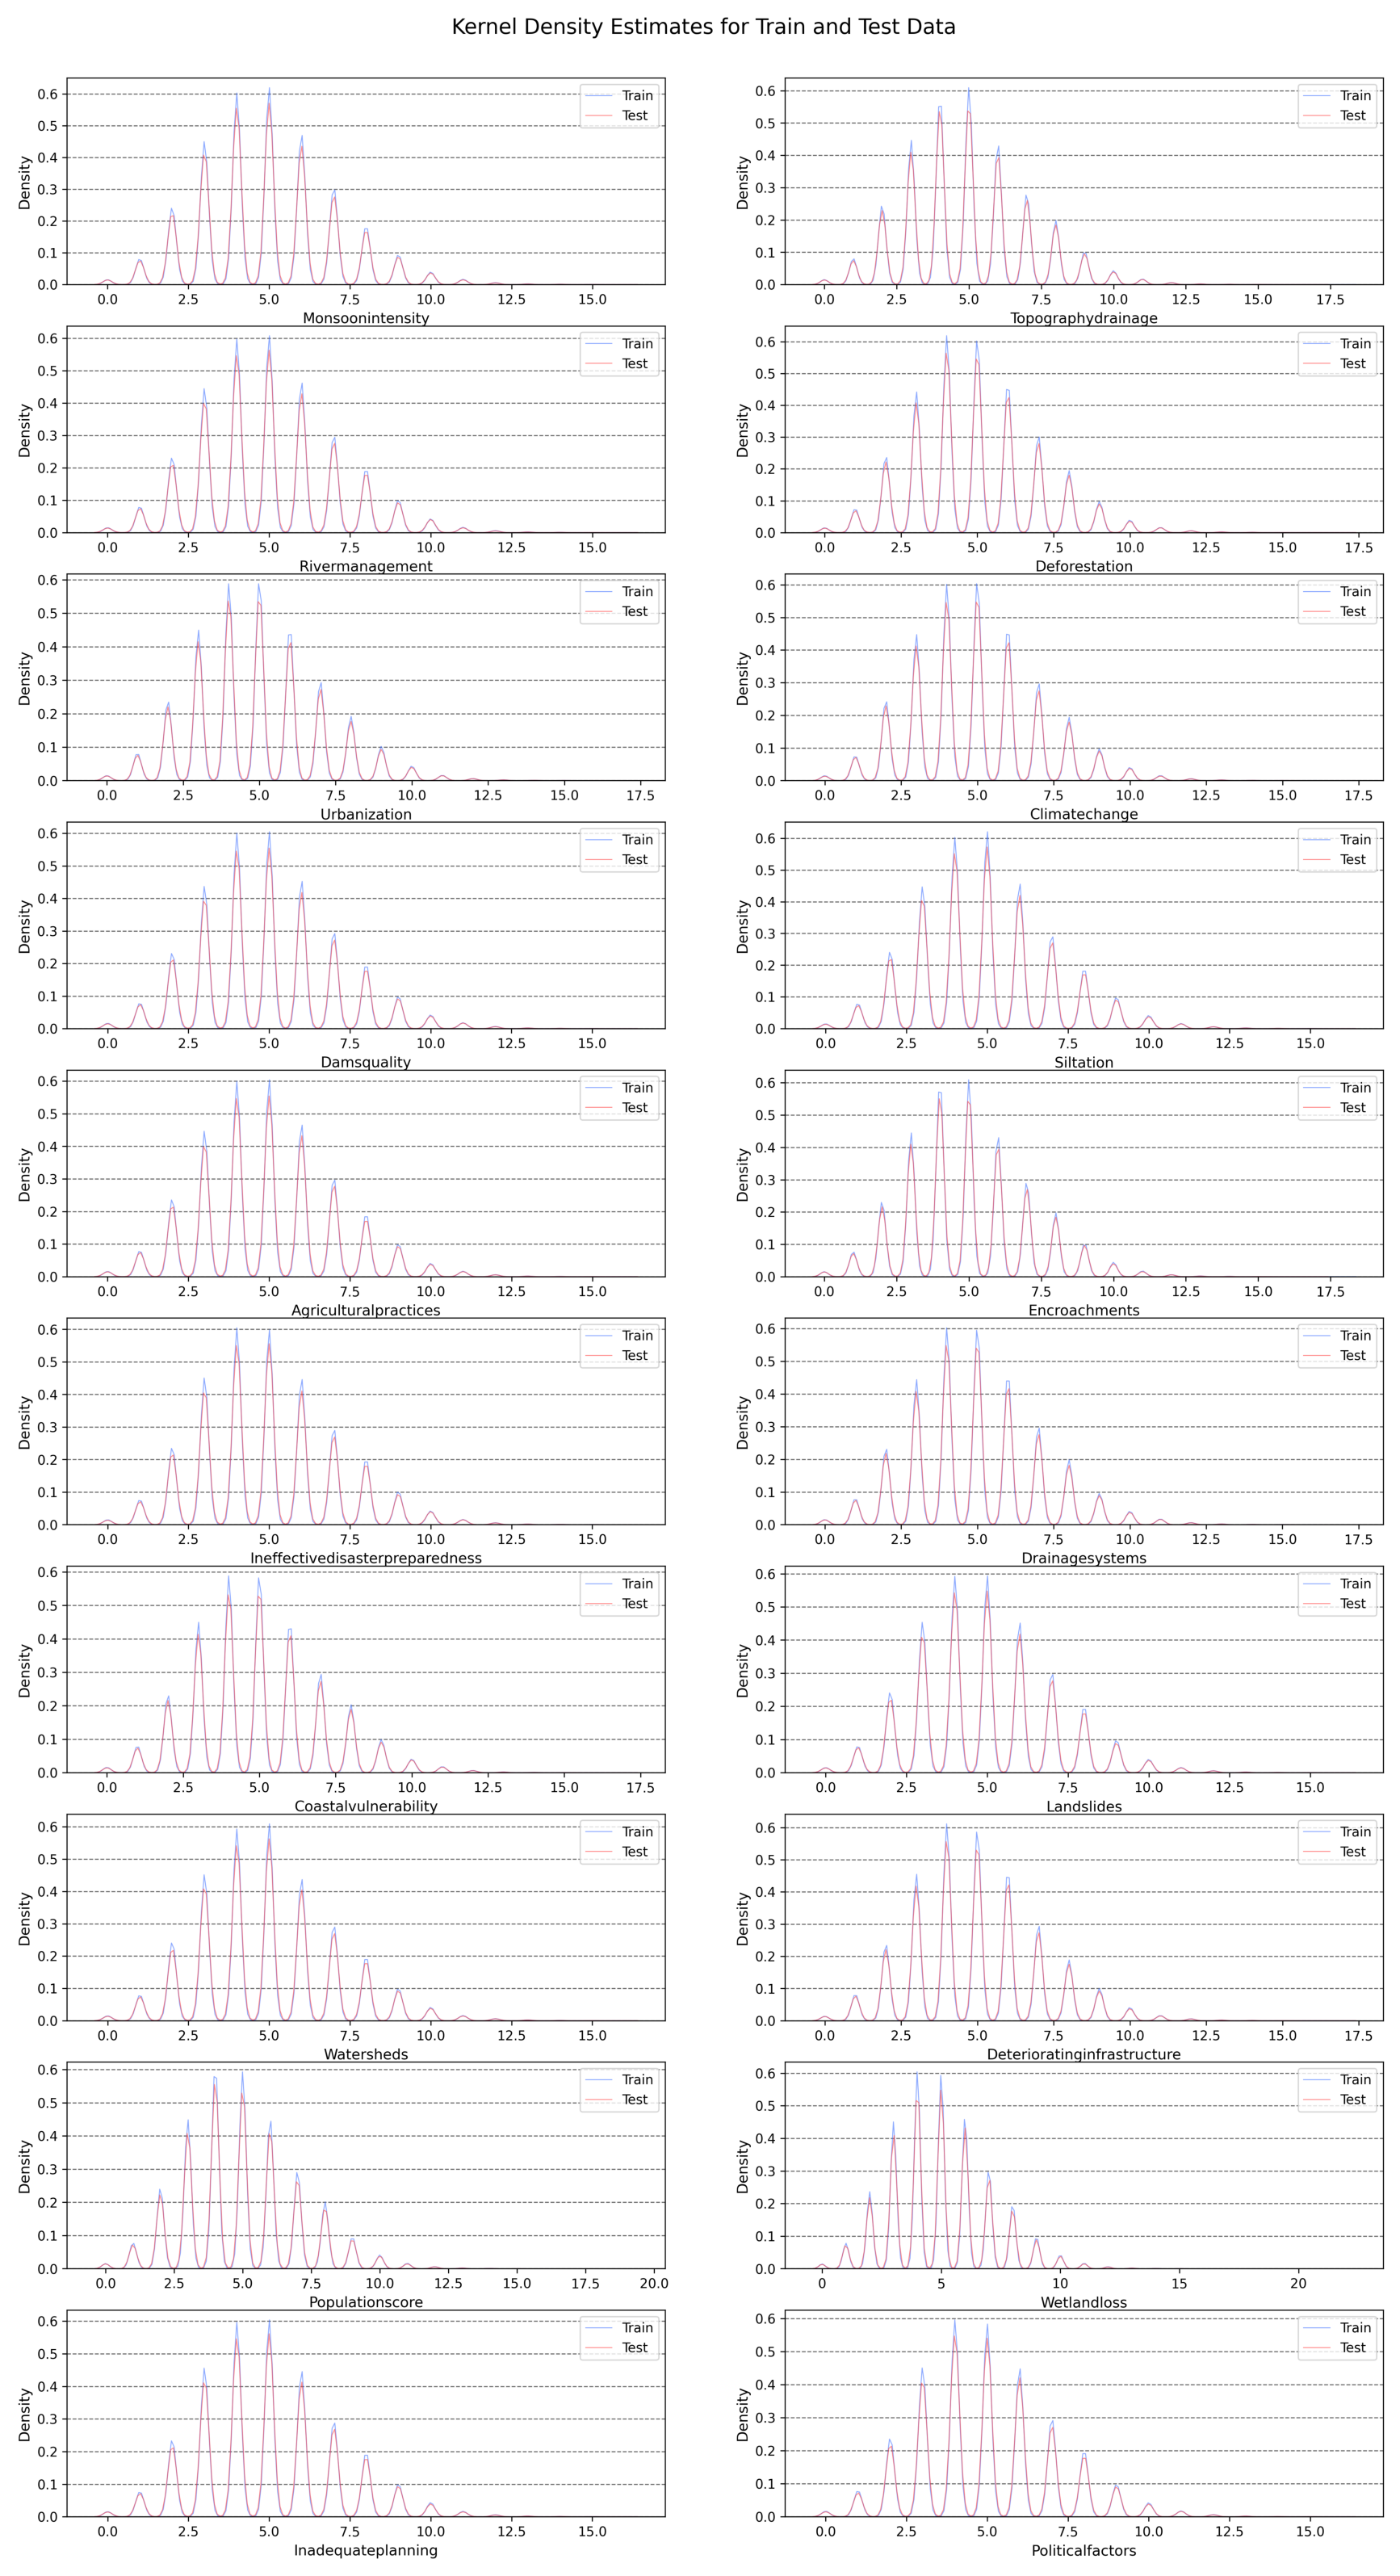

In [9]:
image_path = './img/kde_train_test.png'

plt.figure(figsize=(18, 32))

if not os.path.exists(image_path):
    col_to_plot = df_test.drop(columns= ['id'], axis=1).columns

    plt.suptitle('Kernel Density Estimates for Train and Test Data', fontsize=16, y=1.02)
    plt.subplots_adjust(top=1)

    for i, col in enumerate(col_to_plot):
        ax = plt.subplot(len(col_to_plot) // 2 + 1, 2, i + 1)
        utilities.plot_kde(ax, [df_train, df_test], column=col, color=[COLORS['BLUE'], COLORS['RED']], labels=['Train', 'Test'])

    plt.savefig(image_path, bbox_inches='tight', dpi=300)

else:
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

The distribution of train and test data are identical so no need to rebalance data

Now we check if there is any missing data in the dataset:

In [10]:
pd.DataFrame([df_train.isnull().sum(), df_test.isnull().sum()], index=['TRAIN', 'TEST']).T

,TRAIN,TEST
id,0.0,0.0
MonsoonIntensity,0.0,0.0
TopographyDrainage,0.0,0.0
RiverManagement,0.0,0.0
Deforestation,0.0,0.0
Urbanization,0.0,0.0
ClimateChange,0.0,0.0
DamsQuality,0.0,0.0
Siltation,0.0,0.0
AgriculturalPractices,0.0,0.0


There are no missing values in the dataset, so we can proceed with the analysis.

### <span style="color:#800080; font-style:italic; font-family:Arial;">Data Analysis</span>

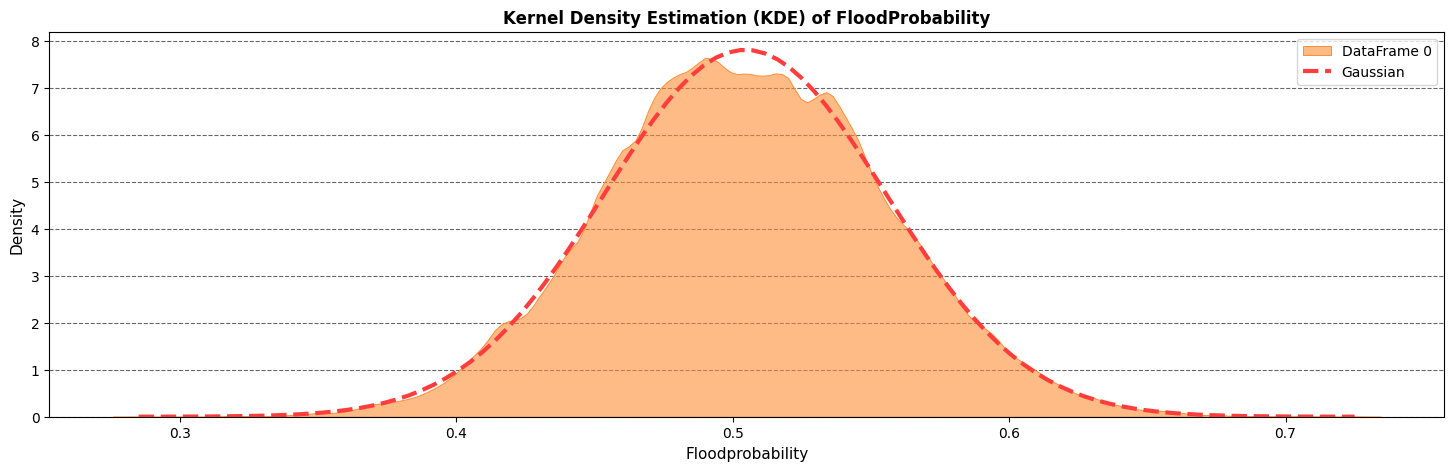

In [11]:
mean = df_train['FloodProbability'].mean()
std_dev = df_train['FloodProbability'].std()
x = np.linspace(df_train['FloodProbability'].min(), df_train['FloodProbability'].max(), 100)
y = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(18, 5))
ax = plt.subplot(111)
target_distrib = utilities.plot_kde(ax, df_train, column='FloodProbability', color=COLORS['ORANGE'], fill=True)
plt.plot(x, y, color=COLORS['RED'], linestyle='--', label='Gaussian', linewidth=3)

plt.legend()
plt.show()

The target distribution seems to match a gaussian distribution.

We then check the correlation between the features:

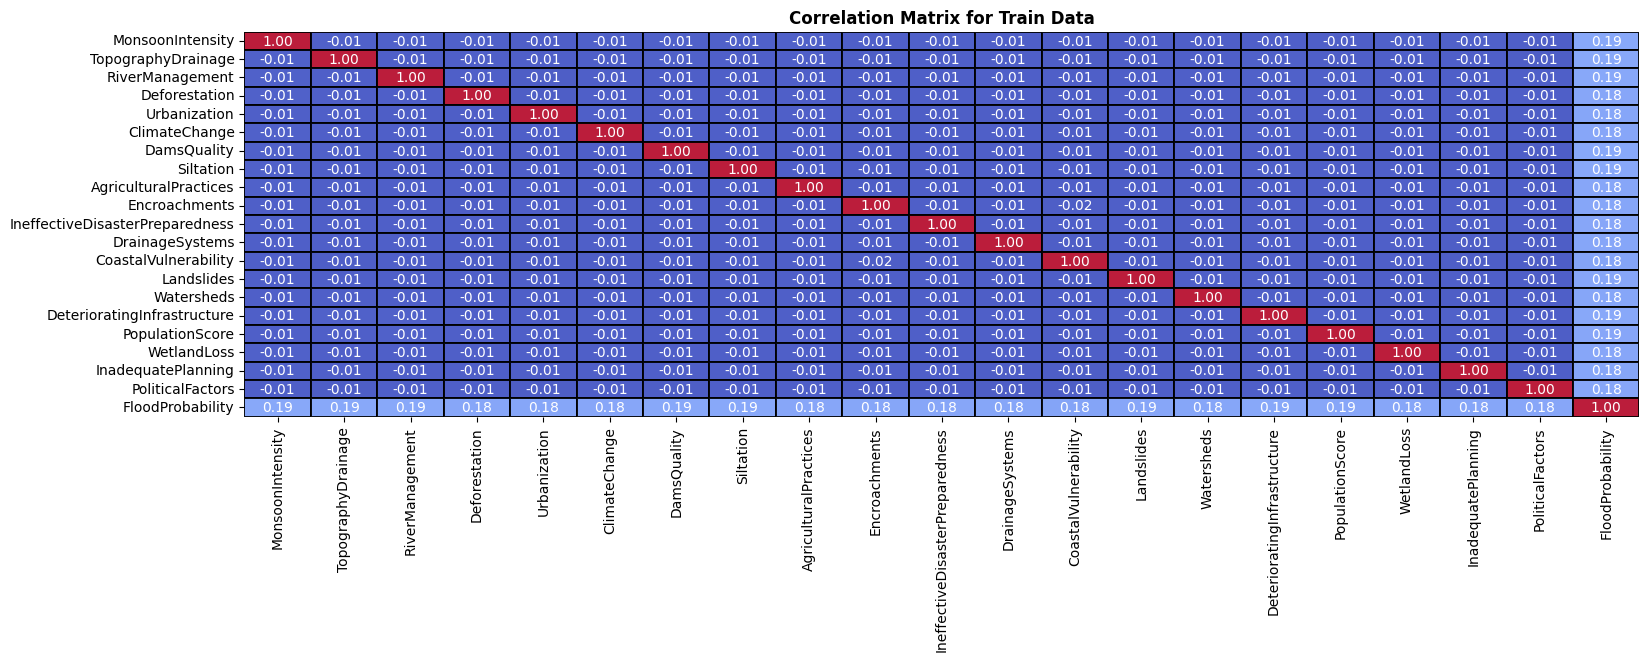

In [12]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(111)
corr_matrix = utilities.plot_correlation_matrix_heatmap(ax, df_train.drop(columns=['id']), title='Correlation Matrix for Train Data', cmap='coolwarm')

The features are not correlated with each other.

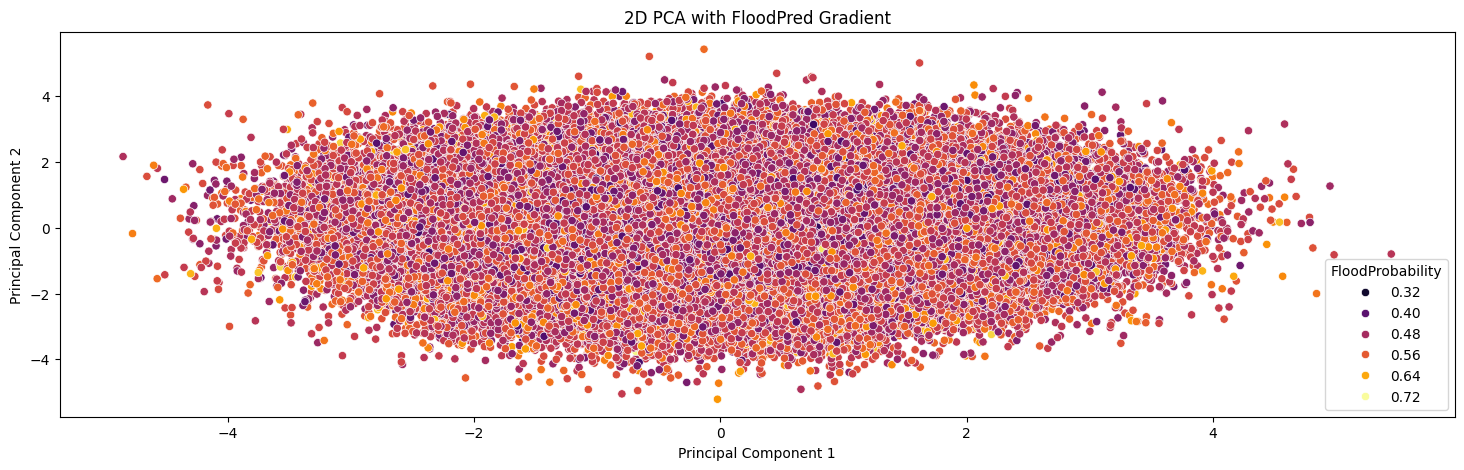

In [13]:
scaler = StandardScaler()
X = df_train.drop(columns=['id', 'FloodProbability'])
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creating a DataFrame with PCA components and FloodPred
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['FloodProbability'] = df_train['FloodProbability'] 

# Plotting
plt.figure(figsize=(18, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='FloodProbability', palette='inferno')
plt.title('2D PCA with FloodPred Gradient')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [14]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.05083696, 0.05080074])

In [15]:
# Use xgb to make predictions
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, df_train['FloodProbability'], test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00041708215798172


In [16]:
# Retrain on the whole dataset
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
model.fit(X, df_train['FloodProbability'])

# Generate CSV file with predictions
y_pred_test = model.predict(df_test.drop(columns=['id']))

submission = pd.DataFrame({'id': df_test['id'], 'FloodProbability': y_pred_test})
submission.to_csv('submission.csv', index=False)